# Whriling Mode High RPM Only
The goal is to show that Tree-based learners are good interpolators but bad extrapolators.
Meaning that the model will give high uncertainty for lower rpms if you include high rpm data only.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

In [3]:
loc = 'nw2'
turbine = 'c02'
mode = 'whirling'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
data_folder = os.path.join(package_folder, 'data')
selected_data= pd.read_parquet(os.path.join(data_folder, 'processed','nw2',mode, turbine+'_' + mode + '_selected_data.parquet'))


In [5]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [6]:
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       #'mvbc_WandelaarMeasuringpile_Air_pressure',
       #'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


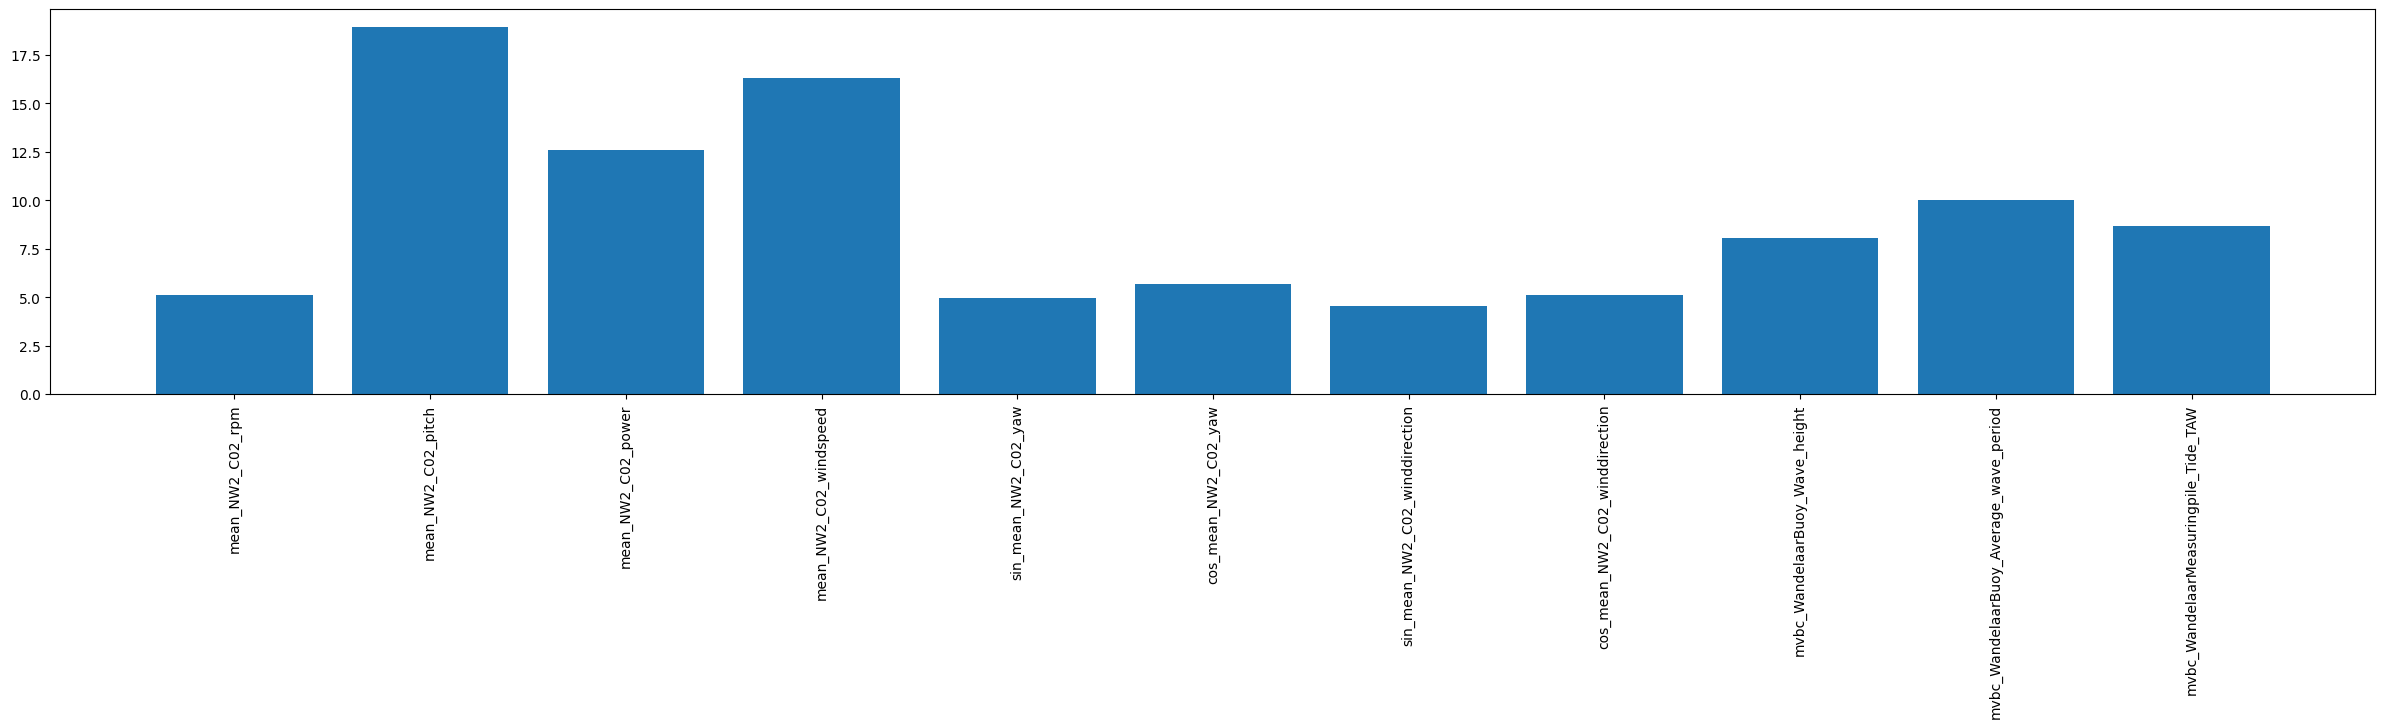

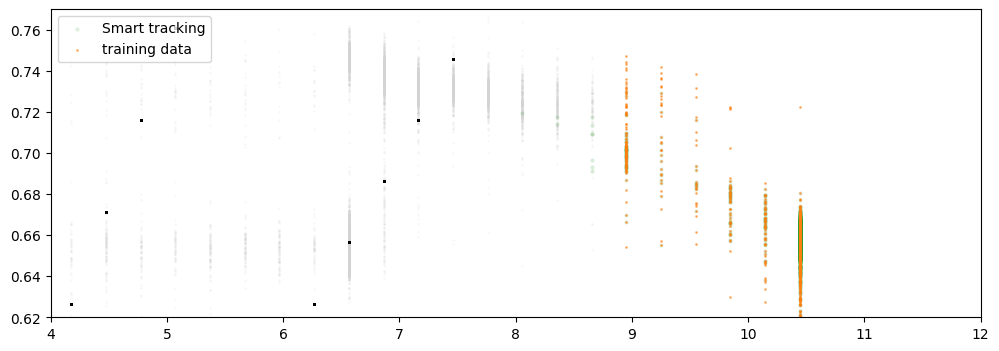

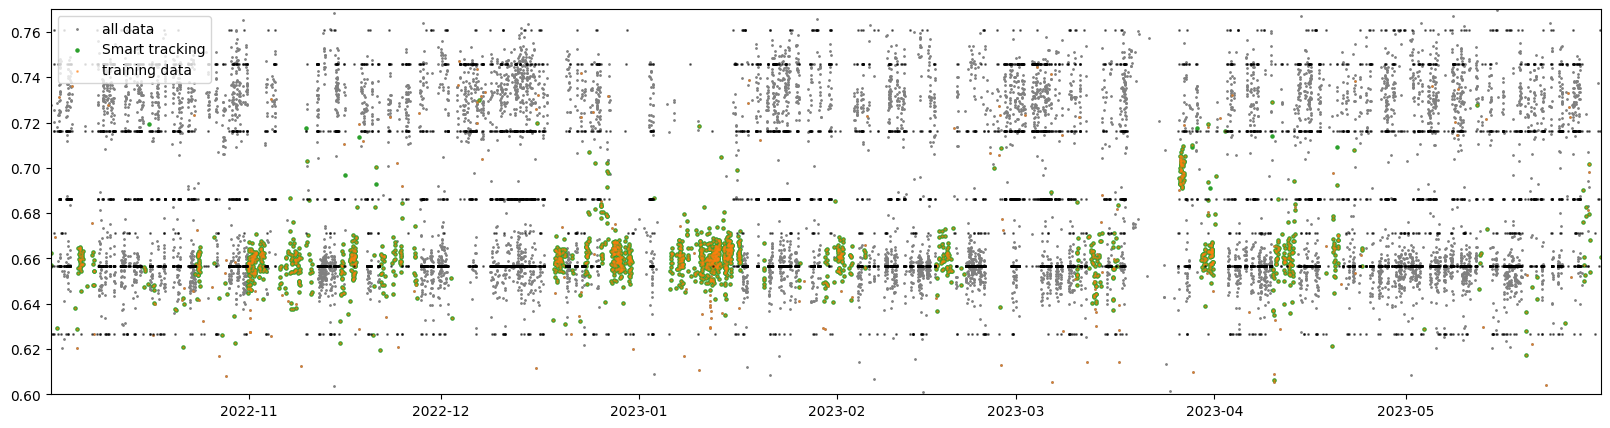

In [7]:
from src.data.make_dataset import create_input_data
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

# High rpm only
X_train = X_train[X_train['mean_NW2_C02_rpm'] > 8.9]
y_train = y_train[X_train.index]

from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=2000, depth=3, learning_rate=0.1, l2_leaf_reg=1, random_seed=0,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)

predictions_df.to_parquet(os.path.join(data_folder, 'processed', loc, mode, turbine + '_' + mode + '_predictions.parquet'))
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.dropna().index].quantile(0.9)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*3

# Smart tracking
from src.smart_tracking.smart_tracking import *

lower_freq = 0.6
upper_freq = 0.77
all_whirling = mpe_ss_data[(mpe_ss_data['mean_frequency'] < upper_freq) & (mpe_ss_data['mean_frequency'] > lower_freq)]

smart_tracked_modes = smart_tracking(
    all_whirling['mean_frequency'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

smart_tracked_modes['rpm'] = X.loc[smart_tracked_modes.index, 'mean_NW2_C02_rpm']
h_X_common_indices = harmonics_data.index.intersection(X.index)
harmonics_data['rpm'] = X.loc[h_X_common_indices, 'mean_NW2_C02_rpm']
common_indices = all_whirling.index.intersection(X.index)
all_whirling_ = all_whirling.loc[common_indices]
all_whirling_['rpm'] = X.loc[common_indices, 'mean_NW2_C02_rpm']

# Show the rpm-frequency plot
plt.figure(figsize=(12,4))
plt.scatter(all_whirling_['rpm'], all_whirling_['mean_frequency'], s=1, alpha=0.1, color='lightgrey')
plt.scatter(smart_tracked_modes['rpm'], smart_tracked_modes['frequency'], s=5, alpha=0.1, color='tab:green', label='Smart tracking')
plt.scatter(X_train.filter(regex='rpm'), y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data['rpm'], harmonics_data[harmonic], color='k', alpha=0.5, s=1)
plt.ylim(0.62, 0.77)
plt.xlim(4,12)
plt.legend(loc='upper left')
plt.show()
plt.close()

plt.figure(figsize=(20,5))
#plt.plot(predictions_df['prediction'], color='tab:orange', linewidth = 0.5, alpha=0.5)

plt.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')
#plt.scatter(predictions_df.index, predictions_df['prediction'],color='tab:blue', s=1, alpha=0.5)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:green', label='Smart tracking')
plt.scatter(y_train.index, y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.xlim(X_train.index[0], X_train.index[-1])
plt.show()
plt.close()

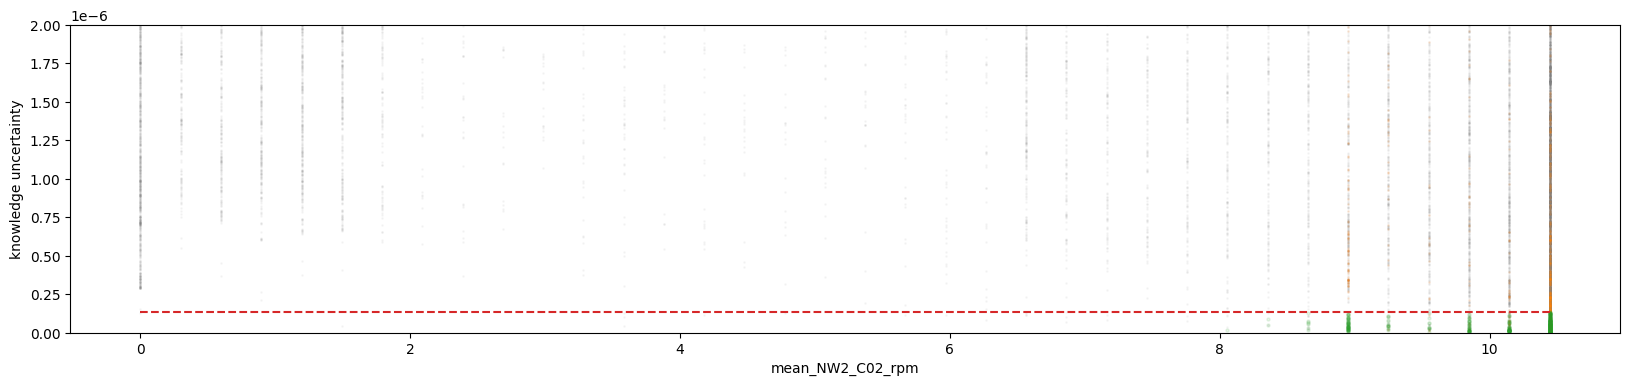

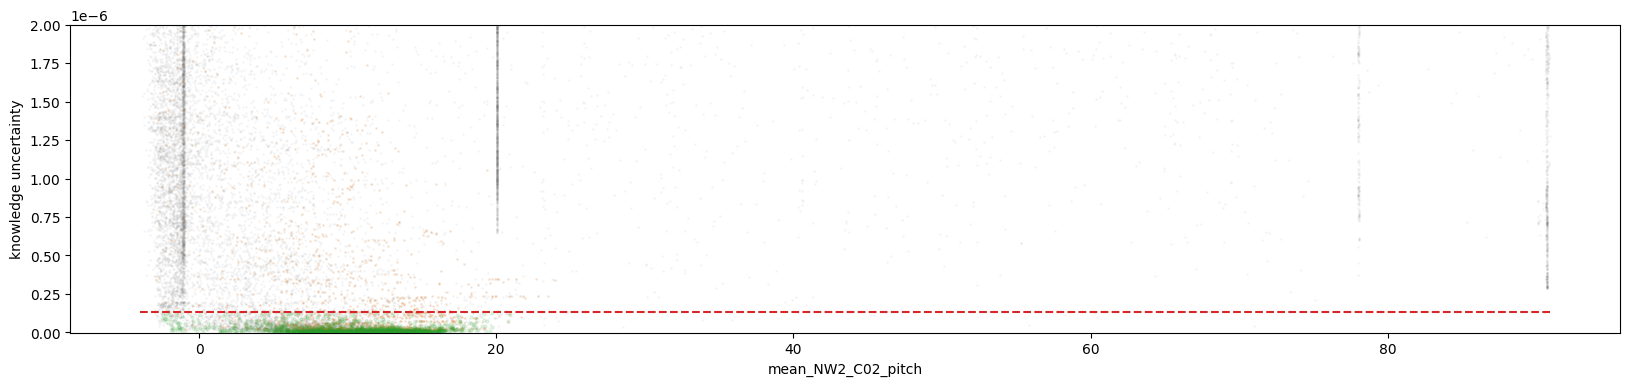

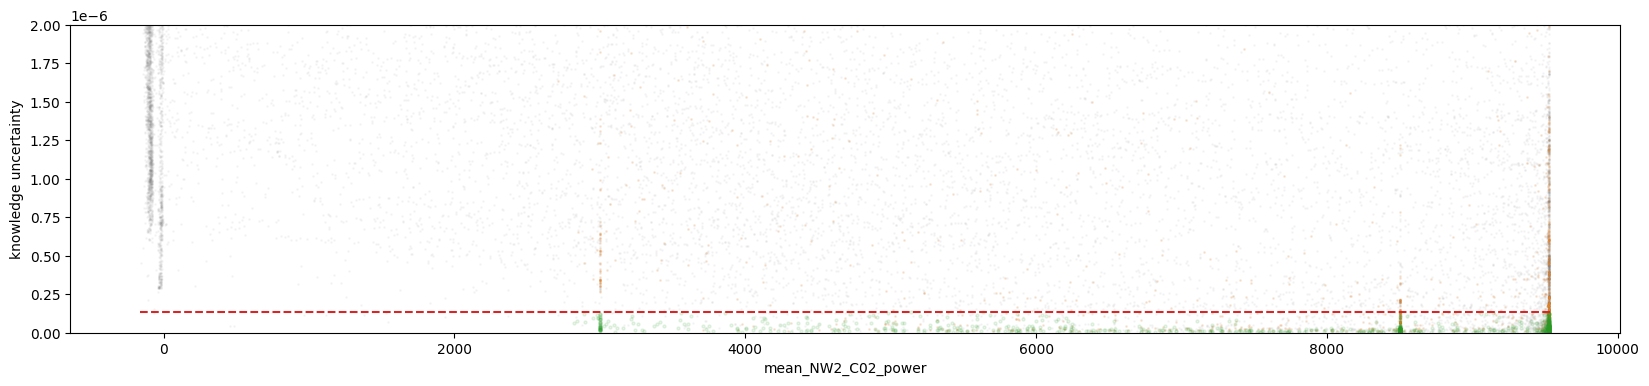

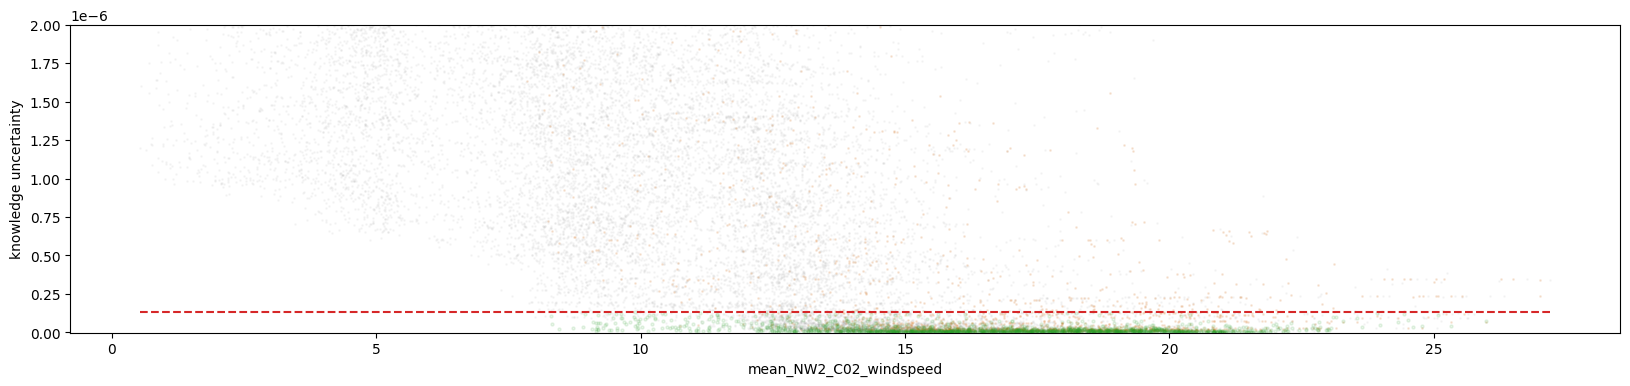

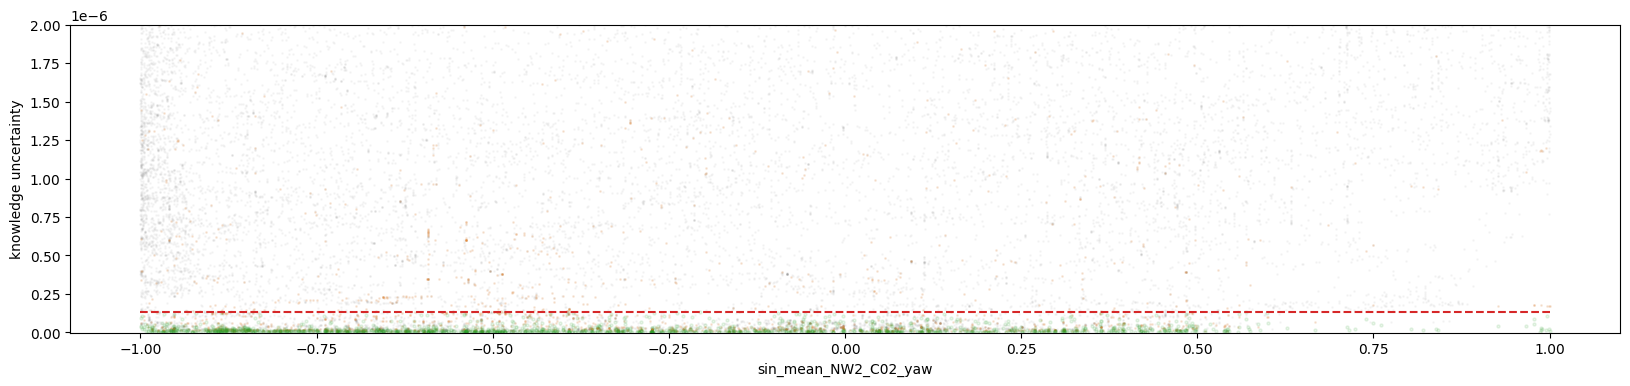

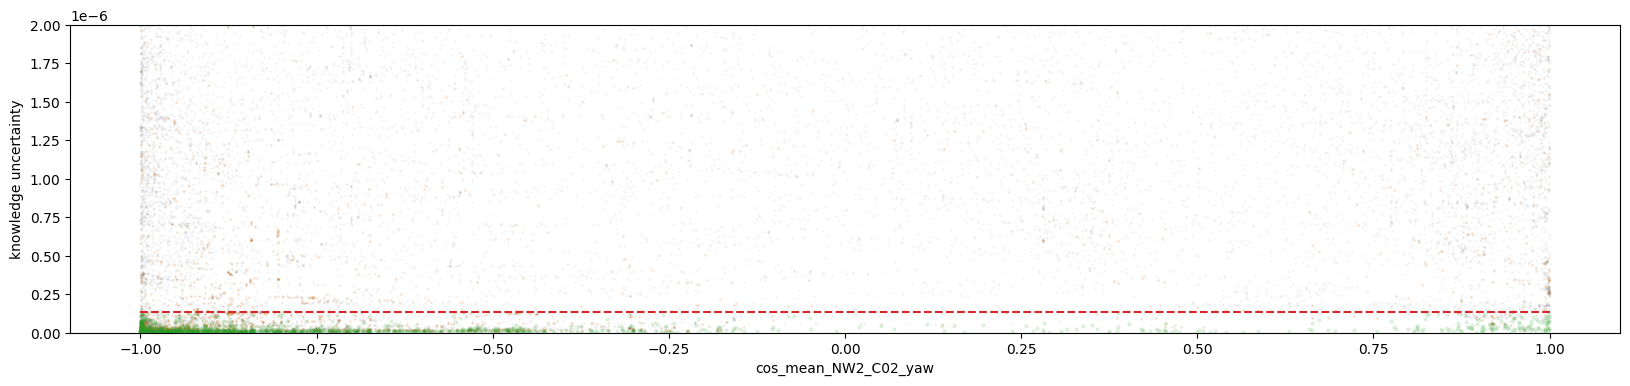

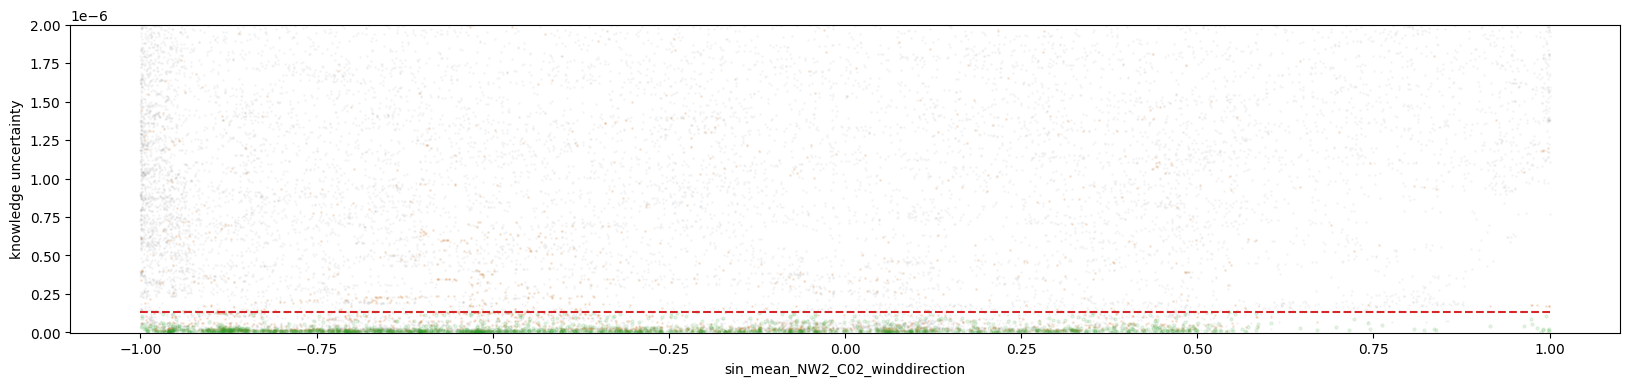

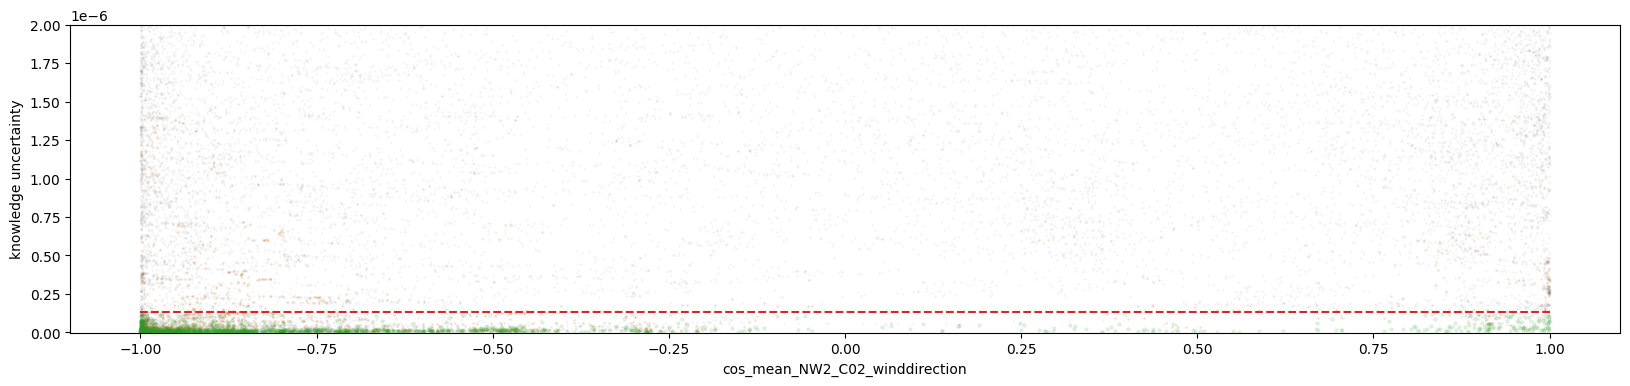

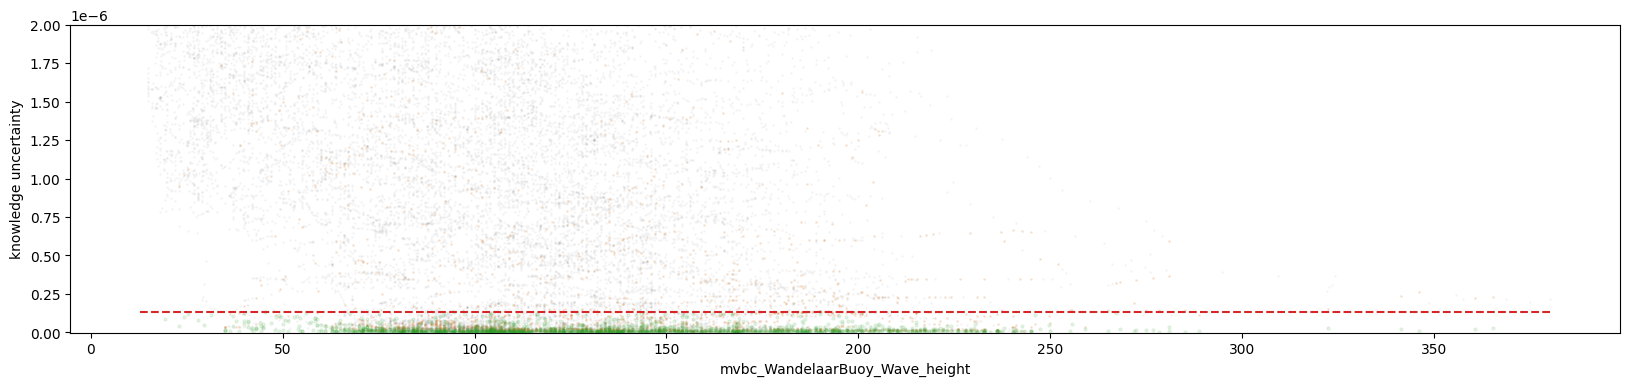

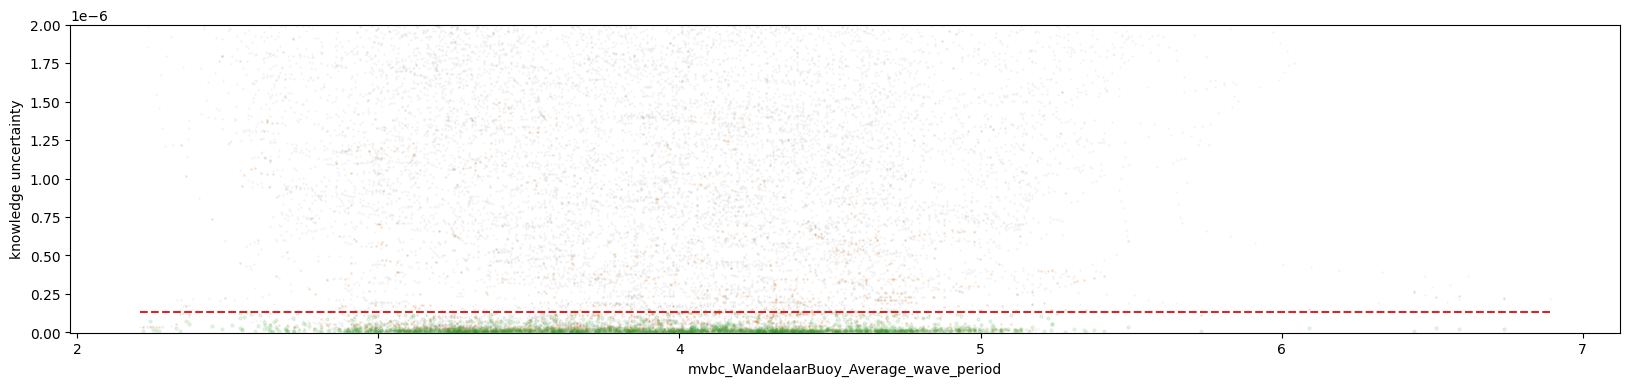

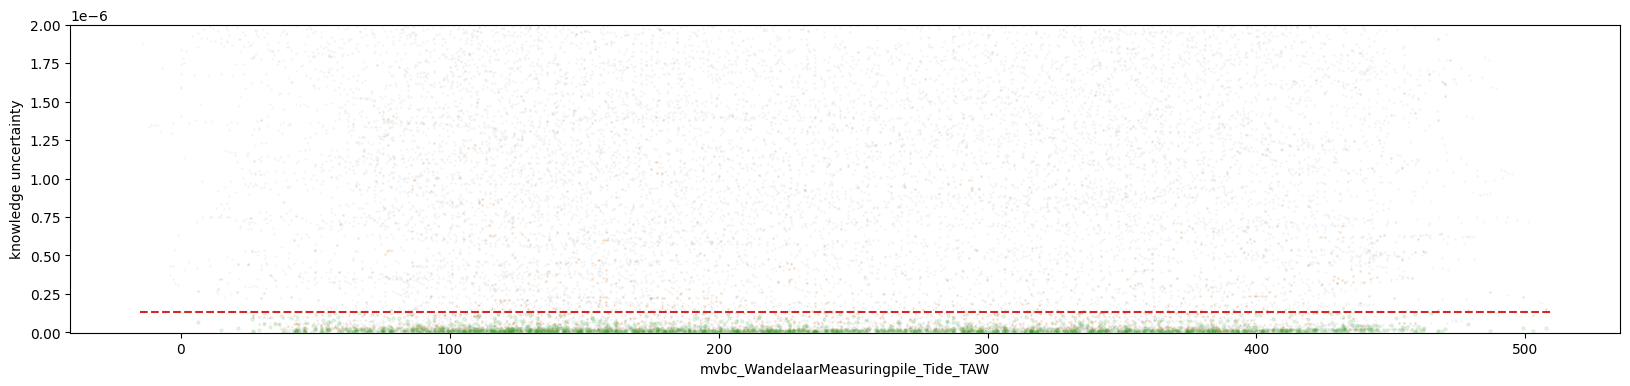

In [8]:
for col in X.columns:
    plt.figure(figsize=(20,4))
    plt.scatter(X[col], uncertainty_moving_avg, s=1, alpha=0.05, color='grey')
    plt.scatter(X[col].loc[X_train.index], uncertainty_moving_avg.loc[X_train.index], s=1, alpha=0.1, color='tab:orange')
    plt.scatter(X[col].loc[smart_tracked_modes.index], uncertainty_.loc[smart_tracked_modes.index], s=5, alpha=0.1, color='tab:green')

    plt.xlabel(col)
    plt.ylabel('knowledge uncertainty')
    plt.ylim(-1e-9, 2*1e-6)
    plt.hlines(uncertainty_lim, X[col].min(), X[col].max(), color='tab:red', linestyles='dashed')
    plt.show()
    plt.close()

## Include data from 8 to 9rpm

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


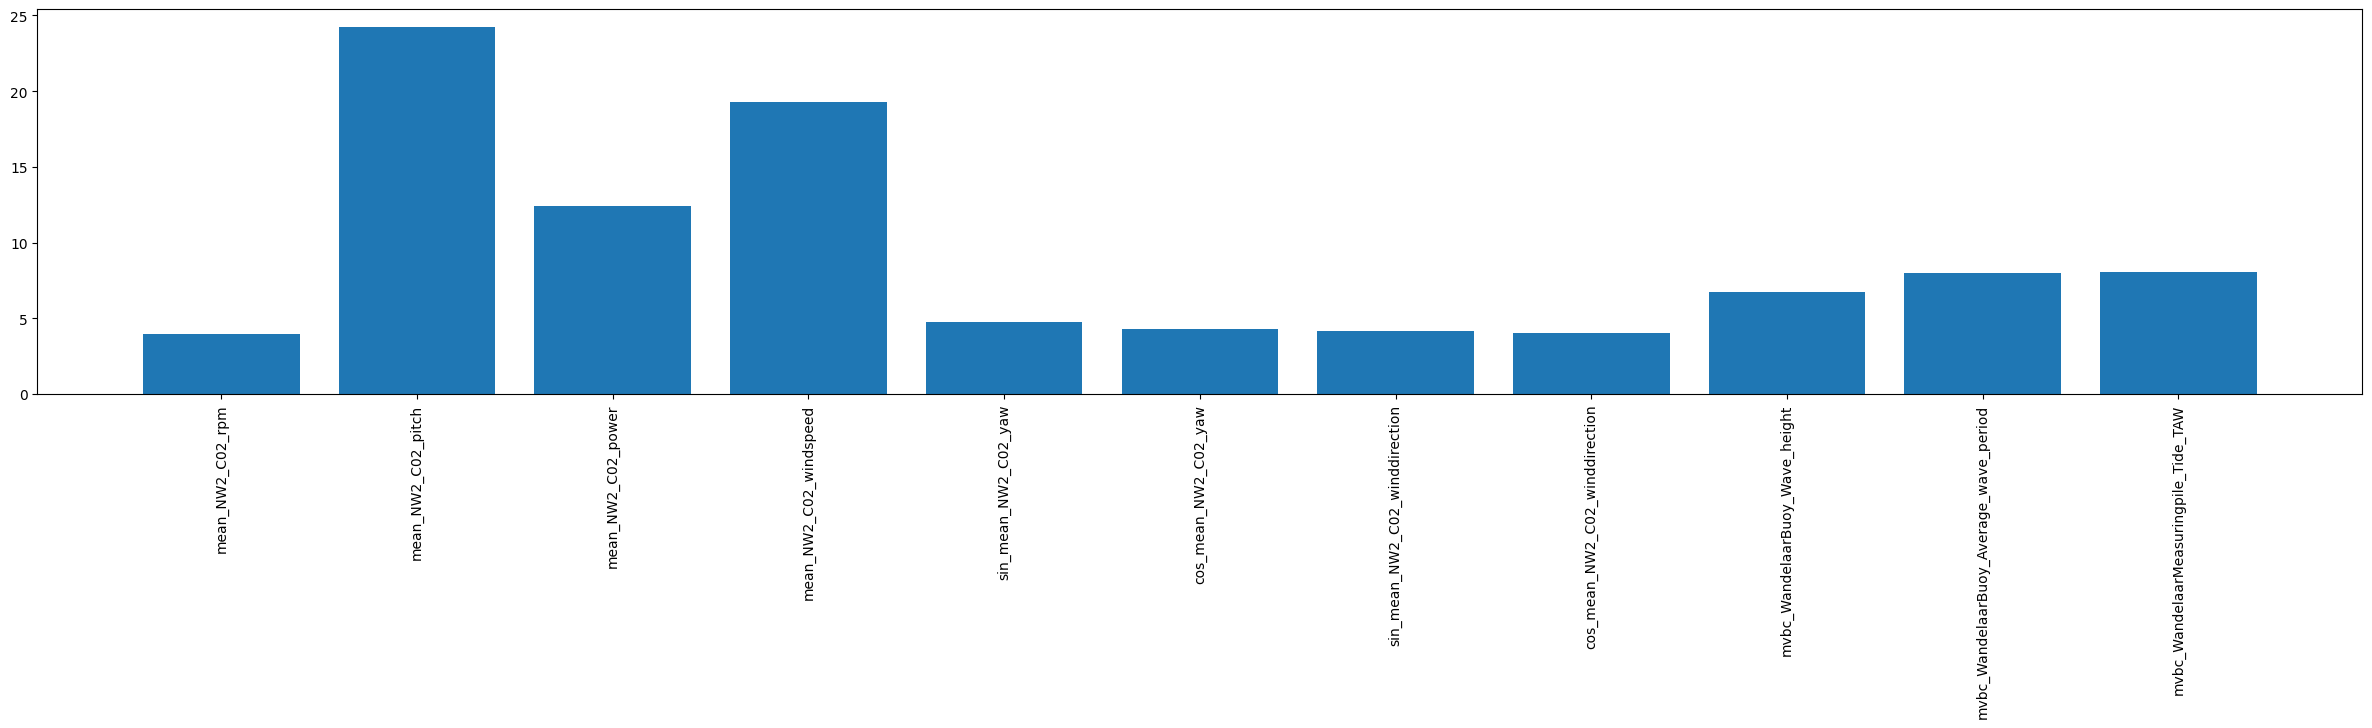

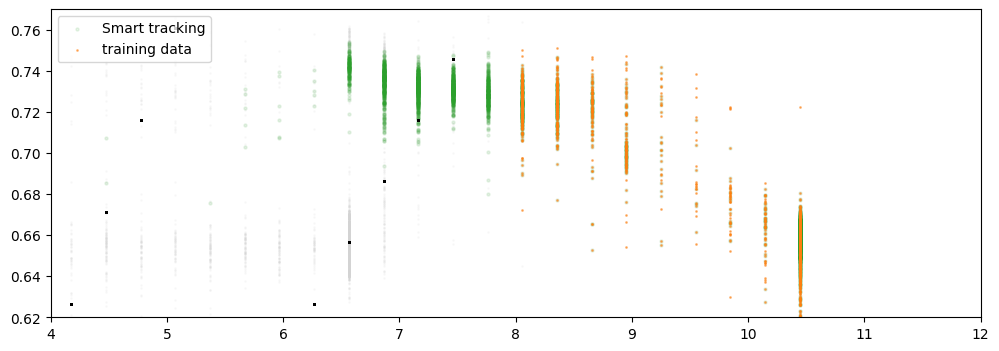

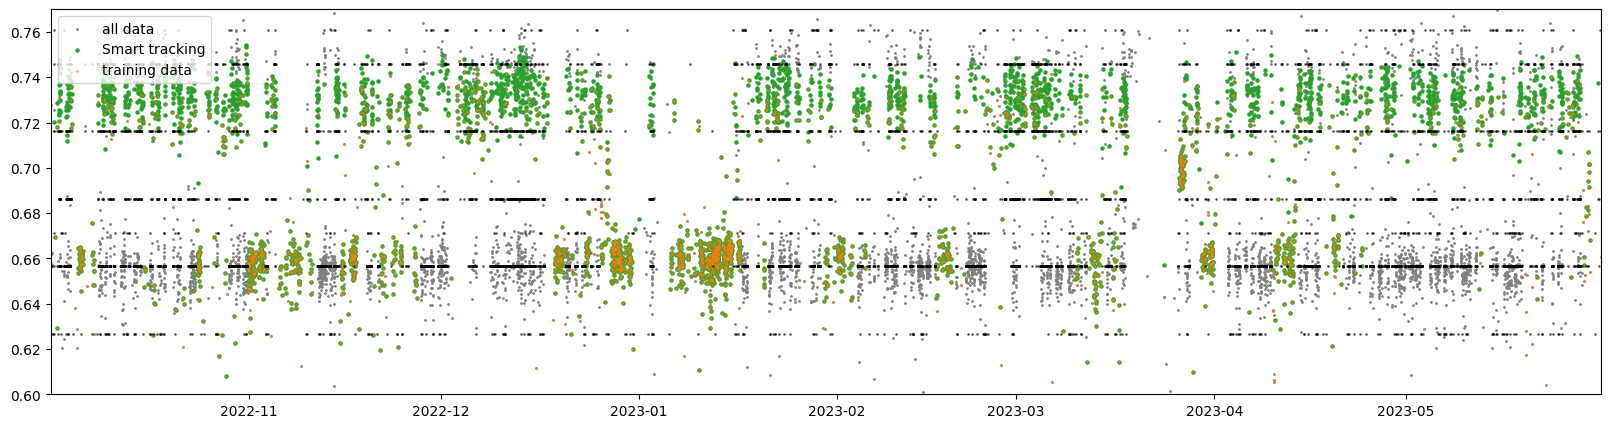

In [9]:
from src.data.make_dataset import create_input_data
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

# High rpm only
#### !The change is here!#
X_train = X_train[X_train['mean_NW2_C02_rpm'] > 8] 
y_train = y_train[X_train.index]

from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=2000, depth=3, learning_rate=0.1, l2_leaf_reg=1, random_seed=0,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)

predictions_df.to_parquet(os.path.join(data_folder, 'processed', loc, mode, turbine + '_' + mode + '_predictions.parquet'))
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.dropna().index].quantile(0.9)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*3

# Smart tracking
from src.smart_tracking.smart_tracking import *

lower_freq = 0.6
upper_freq = 0.77
all_whirling = mpe_ss_data[(mpe_ss_data['mean_frequency'] < upper_freq) & (mpe_ss_data['mean_frequency'] > lower_freq)]

smart_tracked_modes = smart_tracking(
    all_whirling['mean_frequency'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

smart_tracked_modes['rpm'] = X.loc[smart_tracked_modes.index, 'mean_NW2_C02_rpm']
h_X_common_indices = harmonics_data.index.intersection(X.index)
harmonics_data['rpm'] = X.loc[h_X_common_indices, 'mean_NW2_C02_rpm']
common_indices = all_whirling.index.intersection(X.index)
all_whirling_ = all_whirling.loc[common_indices]
all_whirling_['rpm'] = X.loc[common_indices, 'mean_NW2_C02_rpm']

# Show the rpm-frequency plot
plt.figure(figsize=(12,4))
plt.scatter(all_whirling_['rpm'], all_whirling_['mean_frequency'], s=1, alpha=0.1, color='lightgrey')
plt.scatter(smart_tracked_modes['rpm'], smart_tracked_modes['frequency'], s=5, alpha=0.1, color='tab:green', label='Smart tracking')
plt.scatter(X_train.filter(regex='rpm'), y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data['rpm'], harmonics_data[harmonic], color='k', alpha=0.5, s=1)
plt.ylim(0.62, 0.77)
plt.xlim(4,12)
plt.legend(loc='upper left')
plt.show()
plt.close()

plt.figure(figsize=(20,5))
#plt.plot(predictions_df['prediction'], color='tab:orange', linewidth = 0.5, alpha=0.5)

plt.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')
#plt.scatter(predictions_df.index, predictions_df['prediction'],color='tab:blue', s=1, alpha=0.5)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:green', label='Smart tracking')
plt.scatter(y_train.index, y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.xlim(X_train.index[0], X_train.index[-1])
plt.show()
plt.close()

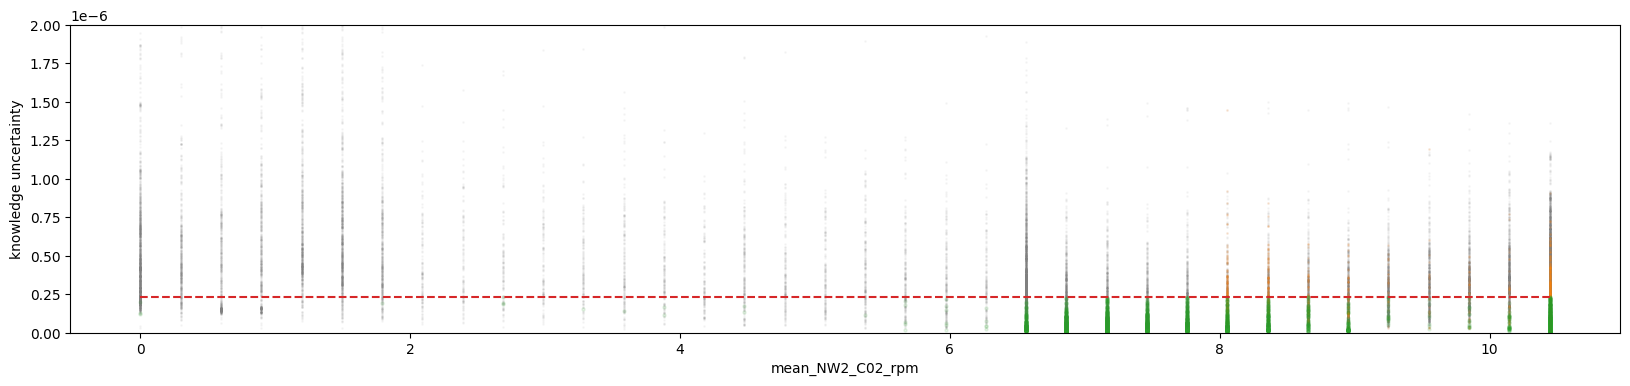

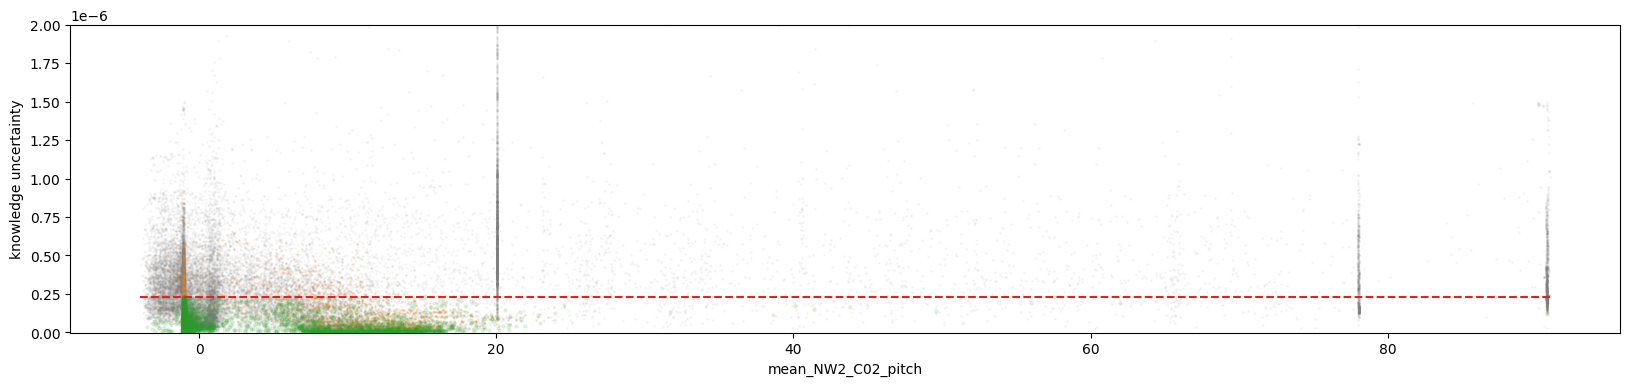

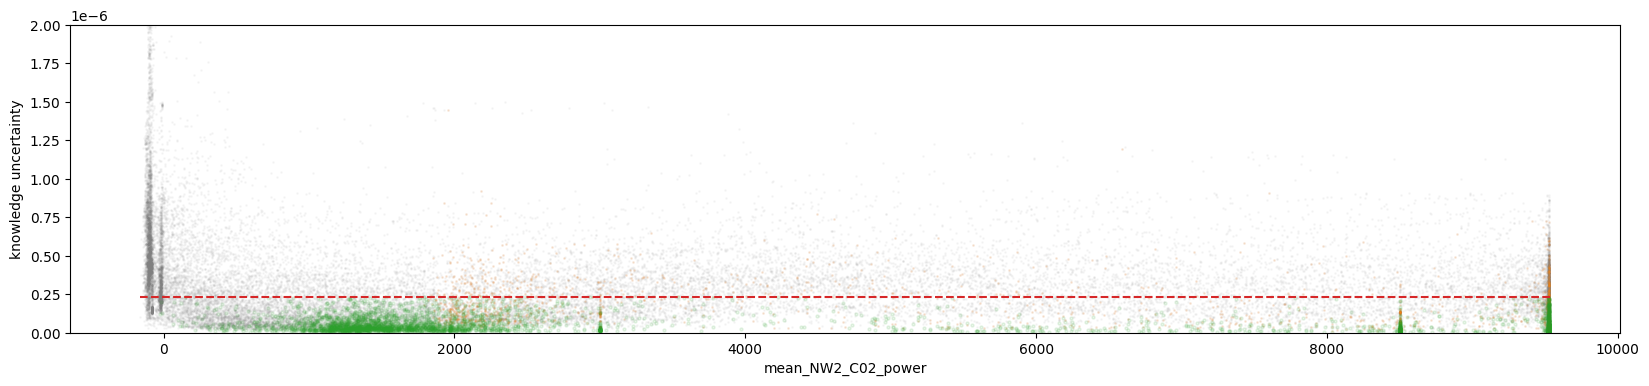

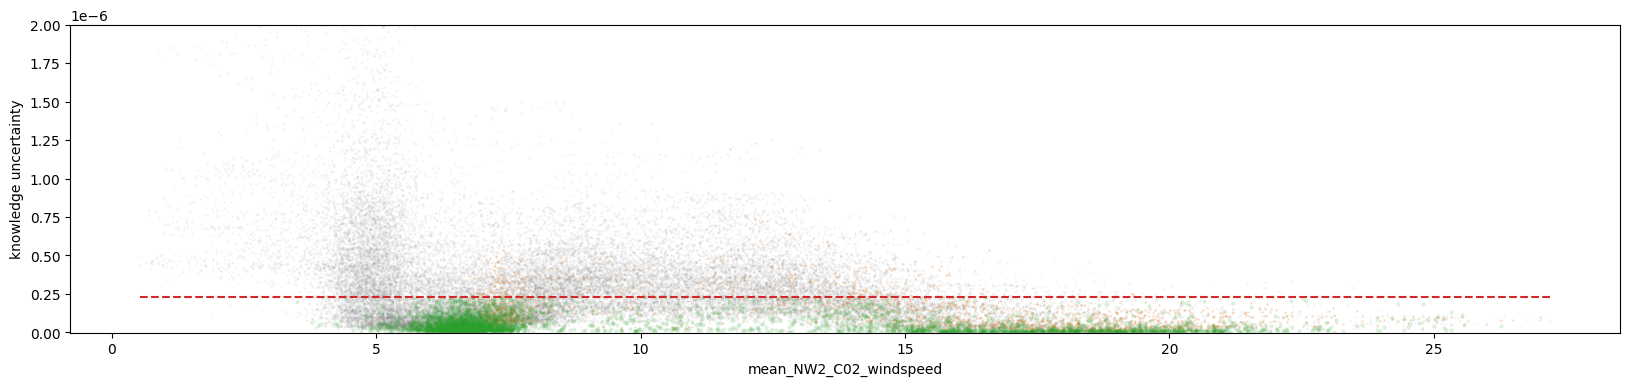

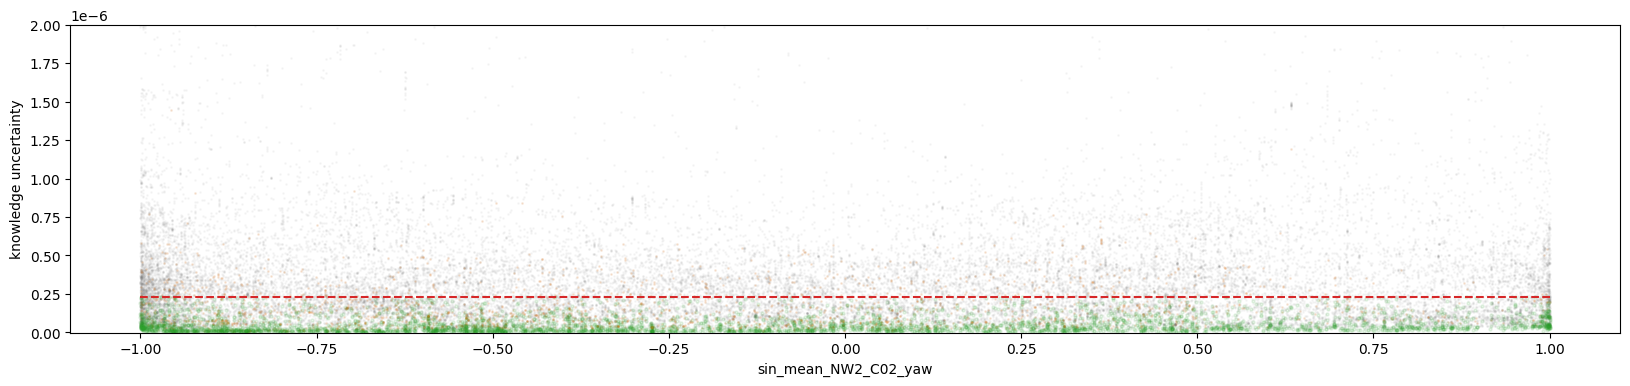

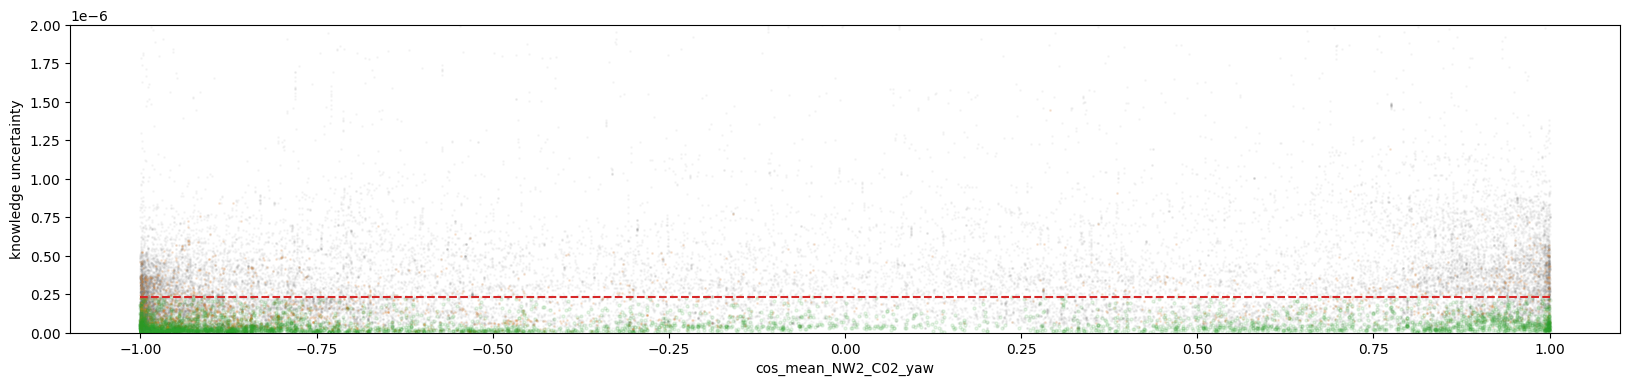

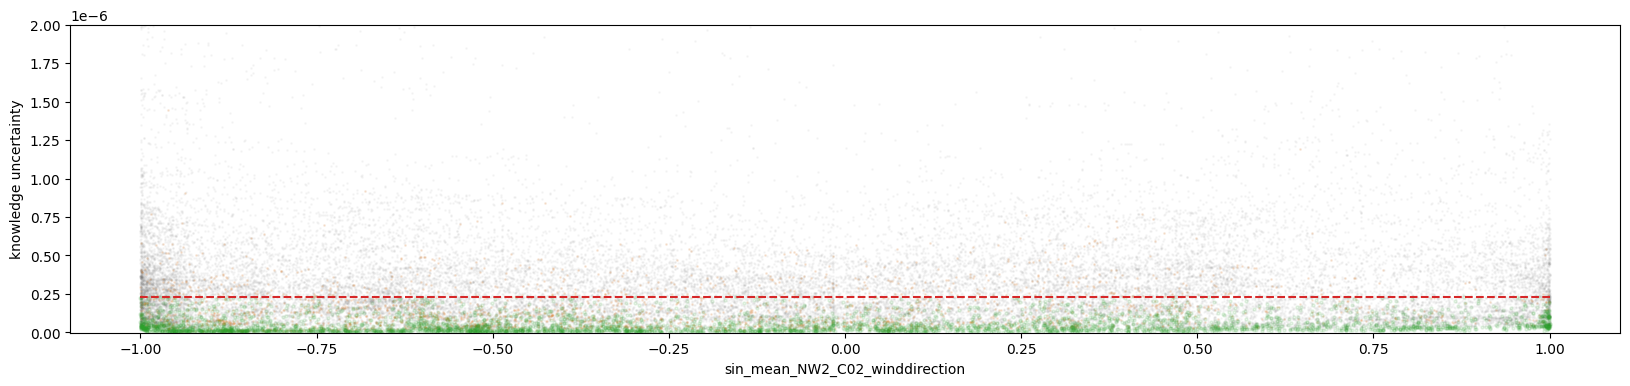

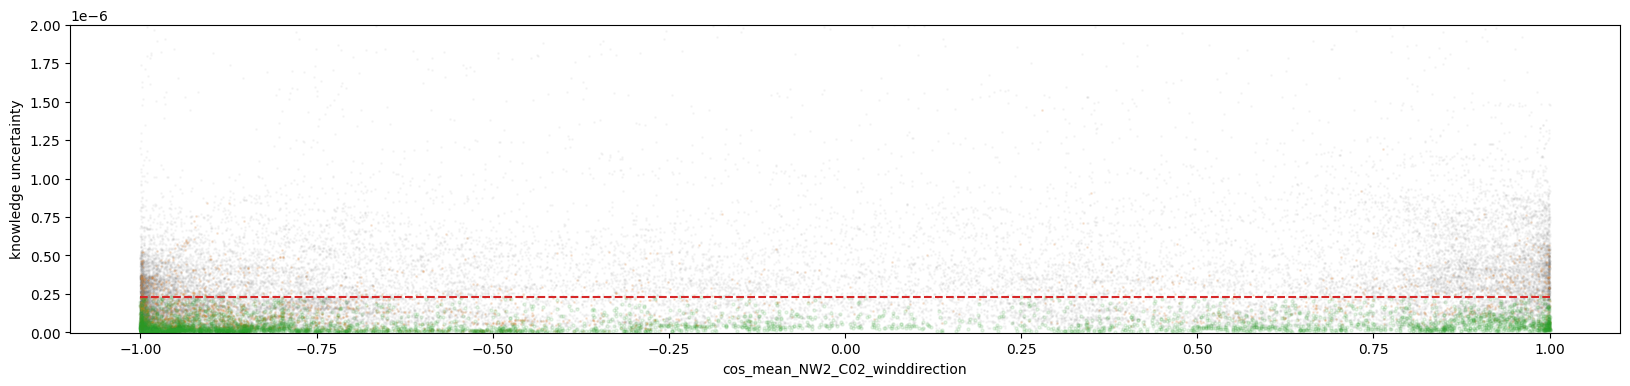

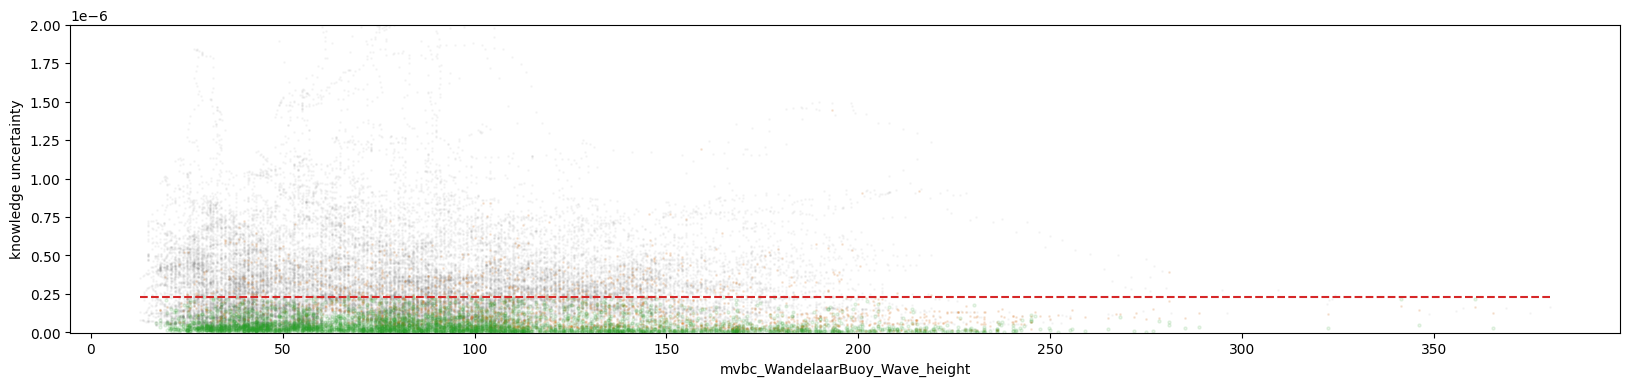

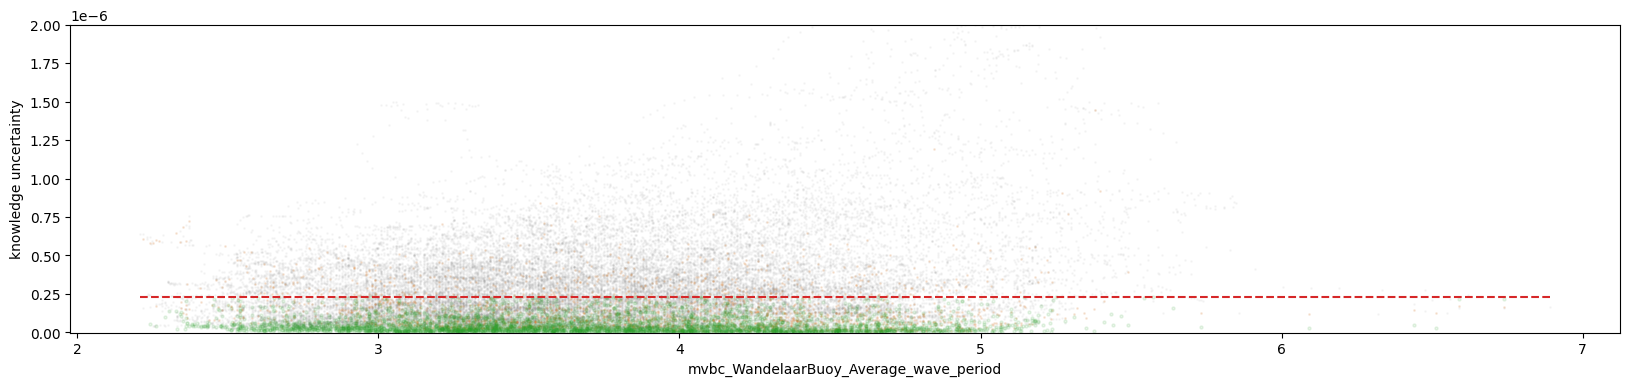

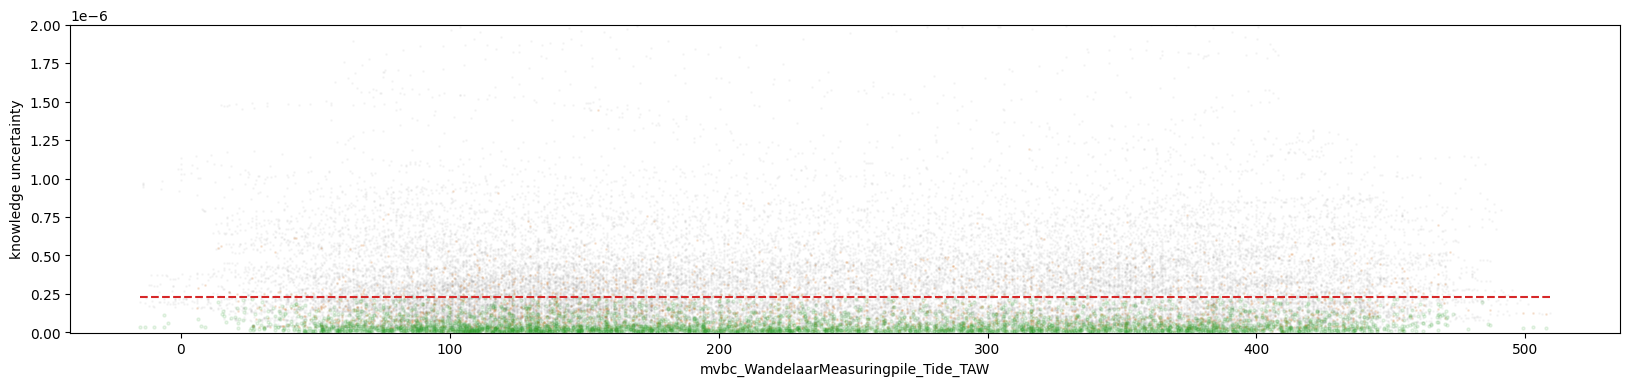

In [10]:
for col in X.columns:
    plt.figure(figsize=(20,4))
    plt.scatter(X[col], uncertainty_moving_avg, s=1, alpha=0.05, color='grey')
    plt.scatter(X[col].loc[X_train.index], uncertainty_moving_avg.loc[X_train.index], s=1, alpha=0.1, color='tab:orange')
    plt.scatter(X[col].loc[smart_tracked_modes.index], uncertainty_.loc[smart_tracked_modes.index], s=5, alpha=0.1, color='tab:green')

    plt.xlabel(col)
    plt.ylabel('knowledge uncertainty')
    plt.ylim(-1e-9, 2*1e-6)
    plt.hlines(uncertainty_lim, X[col].min(), X[col].max(), color='tab:red', linestyles='dashed')
    plt.show()
    plt.close()